In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.2/spark-3.0.2-bin-hadoop2.7.tgz
!tar -xvf spark-3.0.2-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.2-bin-hadoop2.7"
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

spark = SparkSession.builder.getOrCreate()

In [ ]:
spark.read.csv("MsNPC.csv", header=True).createOrReplaceTempView("npcs")
spark.read.csv("MsPlayer.csv", header=True).createOrReplaceTempView("players")
spark.read.csv("MsWeapon.csv", header=True).createOrReplaceTempView("weapons")
spark.read.csv("MsWeaponType.csv", header=True).createOrReplaceTempView("weapon_types")
spark.read.csv("TransactionDetail.csv", header=True).createOrReplaceTempView("transaction_details")
spark.read.csv("TransactionHeader.csv", header=True).createOrReplaceTempView("transaction_headers")

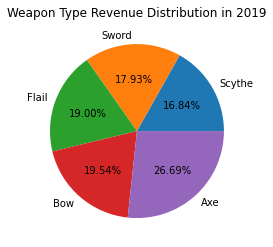

In [ ]:
#show the percentage of weapon type sold for weapon type that is sold
#in 2019 using pie plot
data=spark.sql("""
  select wt.weapontypename, sum(quantity*weaponprice) as revenue
  from weapon_types wt
    join weapons w on wt.weapontypeid = w.weapontypeid
    join transaction_details td on td.weaponid = w.weaponid
    join transaction_headers th on th.transactionid = td.transactionid
  where year(th.transactiondate) = 2019
  group by wt.weapontypeid, wt.weapontypename
  order by revenue
""").toPandas()


plt.pie(data["revenue"], labels=data["weapontypename"], autopct="%.2f%%")
plt.title("Weapon Type Revenue Distribution in 2019")
plt.show()


#display(data)

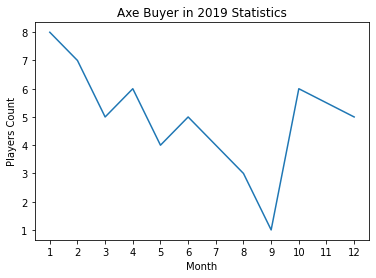

In [ ]:
#show total number of players who bought axe weapon type per month in 2019 using
#line plot. Multiple transaction within the same month will be counted as 1.
data=spark.sql(""" 
select count(distinct th.playerid) as count, month(th.transactiondate) as month
from transaction_headers th
  join transaction_details td on td.transactionid = th.transactionid
  join weapons w on w.weaponid = td.weaponid
  join weapon_types wt on wt.weapontypeid = w.weapontypeid
where year(th.transactiondate) = 2019 and weapontypename = 'Axe'
group by month(transactiondate)
order by month
""" ).toPandas()

plt.plot(data["month"], data["count"])
plt.xticks(range(1,13))
plt.xlabel("Month")
plt.ylabel("Players Count")
plt.title("Axe Buyer in 2019 Statistics")
plt.show()


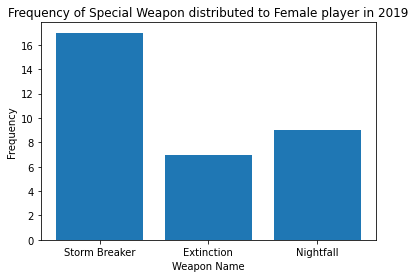

,specialweapon,count
0,Storm Breaker,17
1,Extinction,7
2,Nightfall,9


In [ ]:
#show frequency of special weapon being distributed to female players in 2019
#using bar plot. The player will receive special weapon if their monthly 
#reached the certain condition.

data=spark.sql("""

select specialweapon, count(specialweapon) as count
from (
  select 
    p.playerid,
    sum(weaponprice*quantity) as spending,
    case
      when sum(weaponprice*quantity) between 1000000 and 1499999 then 'Storm Breaker'
      when sum(weaponprice*quantity) between 1500000 and 1999999 then 'Nightfall'
      when sum(weaponprice*quantity) >2000000 then 'Extinction'
    end as specialWeapon
  from players p
    join transaction_headers th on p.playerid=th.playerid
    join transaction_details td on th.transactionid = td.transactionid
    join weapons w on w.weaponid=td.weaponid
  where p.playergender = 'Female' and year(transactiondate)=2019
  group by p.playerid, month(transactiondate)
)
where specialweapon is not null
group by specialweapon

""").toPandas()

plt.bar(data["specialweapon"], data["count"])
plt.title("Frequency of Special Weapon distributed to Female player in 2019")
plt.xlabel("Weapon Name")
plt.ylabel("Frequency")
plt.show()

display(data)

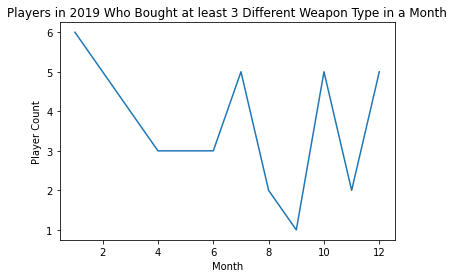

In [ ]:
#show total number of players per month in 2019 who bought
#at least 3 different weapon type in a month using line plot
data = spark.sql("""

select month, count(playerid) as count
from(
    select playerid, month(th.transactiondate) as month
    from transaction_headers th
      join transaction_details td on th.transactionid = td.transactionid
      join weapons w on w.weaponid = td.weaponid
      where year(th.transactiondate)=2019
      group by playerid, month(th.transactiondate)
      having count(distinct weapontypeid) >=3
)
group by month
order by month
""").toPandas()

plt.plot(data["month"], data["count"])
plt.xlabel("Month")
plt.ylabel("Player Count")
plt.title("Players in 2019 Who Bought at least 3 Different Weapon Type in a Month")
plt.show()

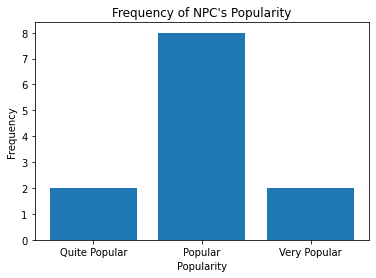

In [ ]:
#show the frequency of NPC's popularity who has done at least transaction
#with 5 different player using bar plot. The popularity is determined based 
#on the income made
data=spark.sql("""
select popularity, count(*) as count
from(
    select n.npcid,
      case
        when sum(quantity*weaponprice) >= 15000000 then 'Very Popular'
        when sum(quantity*weaponprice) between 7500000 and 15000000 then 'Popular'
        when sum(quantity*weaponprice) between 2500000 and 7500000 then 'Quite Popular'
        when sum(quantity*weaponprice) < 2500000 then 'Not Popular'
      end as popularity
    from npcs n
      join transaction_headers th on n.npcid = th.npcid
      join transaction_details td on td.transactionid=th.transactionid
      join weapons w on w.weaponid = td.weaponid
    group by n.npcid
    having count(distinct th.playerid) >=5
)
group by popularity
""").toPandas()

plt.bar(data["popularity"], data["count"])
plt.title("Frequency of NPC's Popularity")
plt.xlabel("Popularity")
plt.ylabel("Frequency")
plt.show()



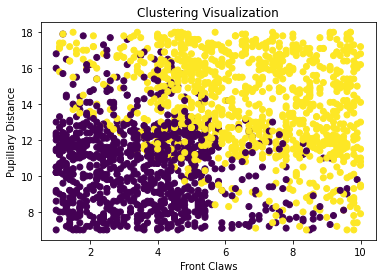

Accuracy:83.6%


In [ ]:
#Clustering
#this case is about proving myths about grizzly bears
#so it asked to make 2 cluster, one for grizzly bear cluster 
#and non-grizzly bear and non gqizzly bear cluster

testing = spark.read.csv("BearTesting.csv", header=True, inferSchema = True)
training = spark.read.csv("BearTraining.csv", header=True, inferSchema=True)

columns = ["Front Claws", "Pupillary Distance", "Ear Shape"]

testing = testing.na.drop()
training = training.na.drop()

testing = testing.select("Front Claws", "Pupillary Distance", "Ear shape", 
                         "Grizzly")
training = training.select(columns)

#transform data
from pyspark.sql.functions import when

testing = testing.withColumn(
    "Ear Shape",
    when(testing["Ear Shape"] == "Pointed", 0)
      .when(testing["Ear Shape"] == "Broad", 1)
      .otherwise(2)
)

testing = testing.withColumn(
    "Grizzly",
    when(testing["Grizzly"] == "No",0).otherwise(1)
)

training = training.withColumn(
    "Ear Shape",
    when(training["Ear Shape"] == "Pointed", 0)
      .when(training["Ear Shape"] == "broad", 1)
      .otherwise(2)
)

#normalization
from pyspark.ml.feature import VectorAssembler, StandardScaler


assembler = VectorAssembler(inputCols = columns, outputCol = 'assembled')
scaler = StandardScaler(inputCol = "assembled", outputCol = "features")

testing = assembler.transform(testing)
training = assembler.transform(training)

testing = scaler.fit(testing).transform(testing)
training = scaler.fit(training).transform(training)

#testing.show()

#generate model
from pyspark.ml.clustering import KMeans
kmeans = KMeans(k=2)
model = kmeans.fit(training)
data = model.transform(testing)
data = data.toPandas()

#visualization
plt.scatter(
    data["Front Claws"],
    data["Pupillary Distance"],
    c=data["prediction"]
)

plt.title("Clustering Visualization")
plt.xlabel("Front Claws")
plt.ylabel("Pupillary Distance")
plt.show()


c = 0
for idc, row in data.iterrows():
  if row["Grizzly"] == row["prediction"]:
    c+=1

#model testing and evaluation
acc = c/len(data)*100
print(f'Accuracy:{acc}%')



In [ ]:
display(data)

,Front Claws,Pupillary Distance,Ear Shape,Grizzly,assembled,features,prediction
0,3.7,11.3,2,0,"[3.7, 11.3, 2.0]","[1.4919151975703926, 3.8607143762417286, 2.693...",1
1,7.8,12.0,2,1,"[7.8, 12.0, 2.0]","[3.145118524607854, 4.099873673885021, 2.69387...",1
2,5.1,11.1,1,1,"[5.1, 11.1, 1.0]","[2.056423650705135, 3.7923831483436445, 1.3469...",0
3,9.1,11.8,0,0,"[9.1, 11.8, 0.0]","[3.66930494537583, 4.031542445986938, 0.0]",1
4,4.6,12.4,1,0,"[4.6, 12.4, 1.0]","[1.8548134888712986, 4.2365361296811885, 1.346...",0
...,...,...,...,...,...,...,...
1995,5.0,16.1,0,0,"[5.0, 16.1, 0.0]","[2.016101618338368, 5.500663845795738, 0.0]",1
1996,6.2,13.8,2,1,"[6.2, 13.8, 2.0]","[2.4999660067395766, 4.714854724967775, 2.6938...",1
1997,8.5,14.7,2,1,"[8.5, 14.7, 2.0]","[3.4273727511752257, 5.022345250509151, 2.6938...",1
1998,9.2,14.1,2,1,"[9.2, 14.1, 2.0]","[3.709626977742597, 4.8173515668149, 2.6938754...",1
